   <h1 align="center">2. Segmentation of coins using OpenCV</h1>

# Installation

### About OpenCV

* <b>OpenCV</b> (Open Source Computer Vision Library) is an library for computer vision and machine learning http://opencv.org/
> contains more than 2500 algorithms

### Installation
* using Anaconda Distribution:
  - create a virtual environment: ```conda create --name opencv```
  - activate it: ```source activate opencv```
  - install OpenCV: ```conda install opencv```
* more information: http://www.swarthmore.edu/NatSci/mzucker1/e27_s2015/install_opencv.html

### Verify the installation

In [11]:
import cv2

### Import other libraries

In [12]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import numpy as np
import argparse
%matplotlib inline
from matplotlib import pyplot as plt, cm

### Visualize the data

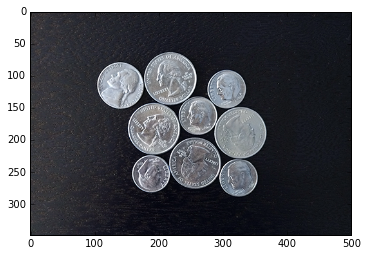

In [13]:
image = cv2.imread("Data/coins_01.png")
plt.imshow(image, cmap='gray')
plt.show()

### Filtering data

* Apply pyramid mean shift filtering to help the accuracy of our thresholding step
* More information about pyramid mean shift filtering: http://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#pyrmeanshiftfiltering

In [14]:
shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)

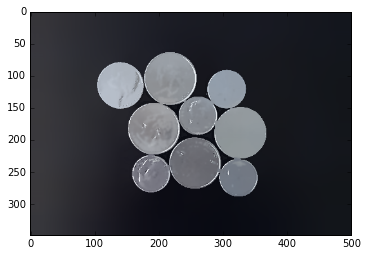

In [15]:
plt.imshow(shifted, cmap='gray')
plt.show()

### Otsu Thresholding

In [16]:
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

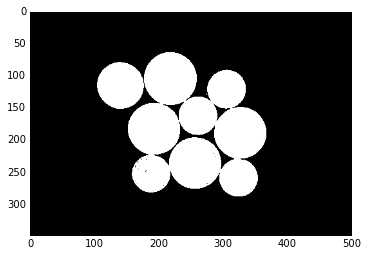

In [17]:
plt.imshow(thresh, cmap='gray')
plt.show()

### Draw contours around the segmented coins

In [18]:
# find contours in the thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)[-2]
print("[INFO] {} unique contours found".format(len(cnts)))
 
# loop over the contours
for (i, c) in enumerate(cnts):
	# draw the contour
	((x, y), _) = cv2.minEnclosingCircle(c)
	cv2.putText(image, "#{}".format(i + 1), (int(x) - 10, int(y)),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
	cv2.drawContours(image, [c], -1, (0, 255, 0), 2)

[INFO] 2 unique contours found


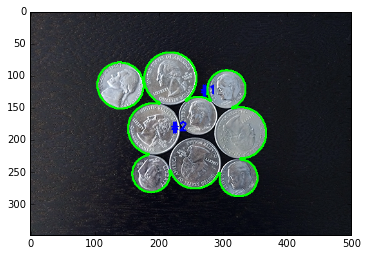

In [19]:
plt.imshow(image, cmap='gray')
plt.show()

* We detected only 2 active contours
* Thresholding not enough in this case
* What is the problem in this image compared with "1_Segmentation_of_electron_microscopy_image_using_skimage"?

### Watershed algorithm

* It classifies pixels into regions using gradient descent on image features and analysis of weak points along region boundaries.
* It is like water raining onto a landscape topology and flowing with gravity to collect in low basins.
* The size of those basins will grow with increasing amount of precipitation until they spill into one other, causing the small basins to merge together into larger basins.
* Reginons (catchment basins) are formed by using local geometric dtructure to associate points in the image domain with local extrema in some feature measurement such as curvature or gradient magnitude.
* <b>Advantage</b>: less sensitive to user-defined thresholds than classic region-growing methods.
* <b>Advantage</b> : It does not produce a single image segmentation, but rather a hierarchy of segmentations.
* More information about Watershed algorithm: https://en.wikipedia.org/wiki/Watershed_(image_processing)

* examples of histogram based thresholding segmentation methods available in SimpleITK: Huang, MaximumEntropy, Triangle, Otsu.
* automatic computation of the threshold based on the histogram of the image

In [20]:
# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=20,
	labels=thresh)
 
# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

[INFO] 9 unique segments found


* The first step in applying the watershed algorithm for segmentation is to compute the Euclidean Distance Transform (EDT) via the distance_transform_edt  function. 
* This function computes the Euclidean distance to the closest zero (i.e., background pixel) for each of the foreground pixels

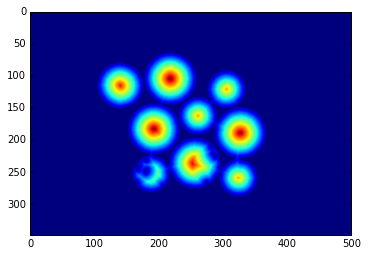

In [21]:
plt.imshow(D)
plt.show()

* We take D, our distance map, and find peaks (i.e., local maxima) in the map. 
* We ensure that is at least a 20 pixel distance between each peak.
* we apply a connected-component analysis using 8-connectivity. The output of this function gives us our markers  which we then feed into the watershed  function.
* Since the watershed algorithm assumes our markers represent local minima (i.e., valleys) in our distance map, we take the negative value of D .

* The watershed  function returns a matrix of labels , a NumPy array with the same width and height as our input image. 
* Each pixel value as a unique label value. Pixels that have the same label value belong to the same object.

* Loop over the unique label values and extract each of the unique objects

In [22]:
# loop over the unique labels returned by the Watershed
# algorithm
for label in np.unique(labels):
	# if the label is zero, we are examining the 'background'
	# so simply ignore it
	if label == 0:
		continue
 
	# otherwise, allocate memory for the label region and draw
	# it on the mask
	mask = np.zeros(gray.shape, dtype="uint8")
	mask[labels == label] = 255
 
	# detect contours in the mask and grab the largest one
	cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)[-2]
	c = max(cnts, key=cv2.contourArea)
 
	# draw a circle enclosing the object
	((x, y), r) = cv2.minEnclosingCircle(c)
	cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
	cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
 

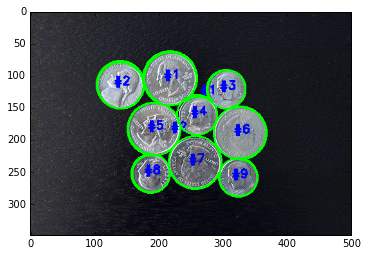

In [23]:
plt.imshow(image)
plt.show()

* Test the method on other images: "coins_02.png", "coins_03.png", "pills_01.png", "pills_02.png"

* Test the method with a photo of the coins on your wallet

### Resources

* Tutorial on image segmentation of coins: http://docs.opencv.org/3.2.0/d3/db4/tutorial_py_watershed.html
* Image Segmentation with Distance Transform and Watershed Algorithm: http://docs.opencv.org/trunk/d2/dbd/tutorial_distance_transform.html
